In [8]:
"""Runs registration algorithm."""

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import time

import loss_utils
import image_field
import warp
import control_point_utils

import sys
sys.path.insert(0, '/Users/noah/Documents/CHU/Ultrasound/lib/image_utils/')

import visualization_utils

tfe = tf.contrib.eager

tf.enable_eager_execution()


ValueError: tf.enable_eager_execution must be called at program startup.

In [9]:
from typing import Tuple, Union, List


In [2]:
dataset_path = "/Users/noah/Documents/CHU/Ultrasound/raw_data/heart_rotation"

num_steps = 200
learning_rate = .5
beta = .4
beta_2 = .99
warp_points = (8, 8)
initial_scale = 7.
scale_tuner_alpha = 1.2
elastic_weight = 1.
elastic_weight_scale = 0.25057652344002182

save_dir = "/Users/noah/Documents/CHU/Ultrasound/experiment_results/8_22_registration"

if not os.path.exists(save_dir):
  os.makedirs(save_dir)

images_file = os.path.join(dataset_path, 'raw_images.npy')
data_temp = np.load(images_file).astype(np.float32)

print(data_temp.shape)



(9, 623, 512)


In [ ]:
import elastic_image
import warp_parameters


def load_image_demons(
    image: tf.Tensor,
    initial_non_rigid_values_or_scale: Union[List[float], float]
):
  """Creates ElasticImage object with variables for image flow 
  demons registration.

  Args:
    image: tf.Tensor of shape [height, width].
    initial_non_rigid_values_or_scale: Either a List of intial displacements
      control_point grid or a float which parameterizes the scale of random
      initialization. See `warp_parameters.make_elastic_warp_variable`.


  Returns:
    ElasticImage object containing image and variables for each
    point displacement.
  """
    
  xx, yy = np.meshgrid(np.arange(data_temp.shape[1]),
                       np.arange(data_temp.shape[2]))

  control_points = np.stack([xx, yy], -1)
  control_points = np.reshape(control_points, [-1, 2])

  control_points = tf.convert_to_tensor(control_points)

  eimage = elastic_image.ElasticImage(image, control_points, )

  non_rigid = warp_parameters.make_elastic_warp_variable(
    control_points.get_shape().as_list()[0], initial_non_rigid_values_or_scale)
  eimage.add_to_variable_dict(non_rigid, "non_rigid")

  return eimage

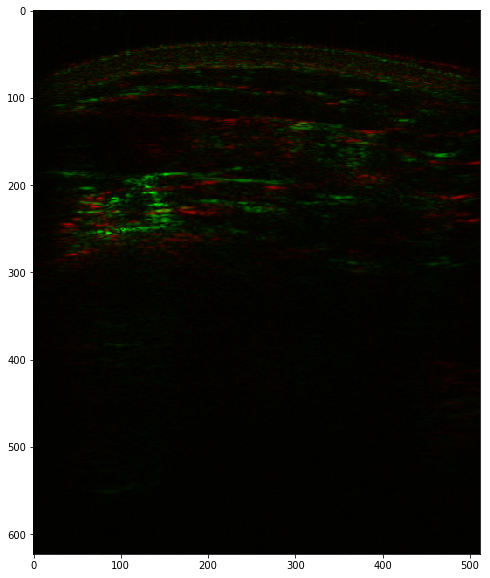

In [242]:

# Load first two images.
image_a = data_temp[0]
image_b = data_temp[1]



# add noise to images (may want to do this as layer)
def gaussian_noise_layer(input_layer, std):
    "Adds noise > 0"
    noise = tf.truncated_normal(shape=tf.shape(input_layer), mean= 2 * std, stddev=std, dtype=tf.float32) 
    return input_layer + noise
image_a = gaussian_noise_layer(tf.convert_to_tensor(image_a), 1.)
image_b = gaussian_noise_layer(tf.convert_to_tensor(image_b), 1.)

image_a = load_image_demons(image_a,  1.)
image_b = load_image_demons(image_b, 1.)

# Display.
plt.figure(figsize=(20,10))
plt.imshow(visualization_utils.multiple_intensity_to_rgb(image_a.image.numpy(),
                                             image_b.image.numpy()))



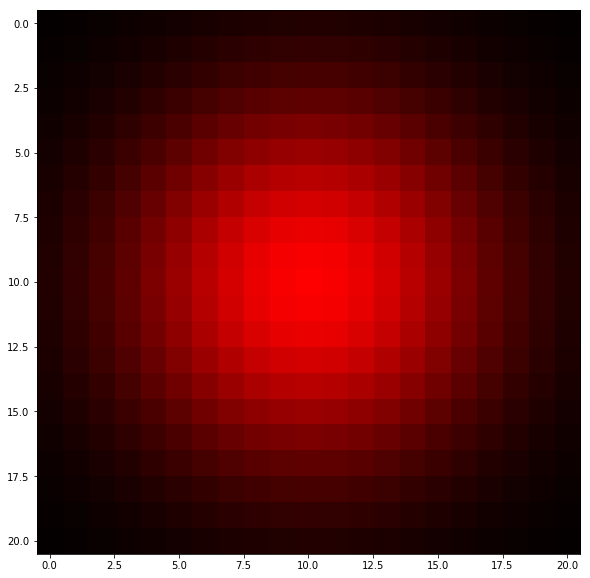

In [280]:
# 2D Gaussian Kernel
def gaussian_kernel(size: int,
                    mean: float,
                    std: float,
                   ):
    """Makes 2D gaussian Kernel for convolution."""

    d = tf.distributions.Normal(mean, std)

    vals = d.prob(tf.range(start = -size, limit = size + 1, dtype = tf.float32))

    gauss_kernel = tf.einsum('i,j->ij',
                                  vals,
                                  vals)

    gauss_kernel = gauss_kernel / tf.reduce_sum(gauss_kernel)
    gauss_kernel = tf.stack([gauss_kernel, tf.zeros_like(gauss_kernel)], axis=2)
    gauss_kernel = tf.stack([gauss_kernel, gauss_kernel[:, :, ::-1]], axis=3)
    return gauss_kernel

gauss_kernel = gaussian_kernel(10, 0., 5.)

plt.figure(figsize=(20,10))
plt.imshow(visualization_utils.multiple_intensity_to_rgb(gauss_kernel[:,:,0,0].numpy()))

In [281]:
def _grid_convolve(tensor, correlation_kernel):
    """Convolves tensor with kernel.

    Args:
        tensor: Tensor of shape [N, W, H, 2].
        correlation_kernel: Kernel to evaluate correlation.  Shape [C, C, 2, 2]

    Returns:
        convolved: tensor convolved with correlation_kernel
    """
    # Symmetric padding ensures that tensors along the edge are not penalized
    pad_size = ( gauss_kernel.shape.as_list()[0] - 1 ) / 2

    tensor = tf.pad(tensor, [[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode="SYMMETRIC")
    
    return  tf.nn.conv2d(tensor, correlation_kernel, strides=[1, 1, 1, 1], padding="VALID")



In [282]:
for _ in range(20):
    time_step_start = time.time()
    # WARP IMAGES

    # Moving image.
    # warped_values is list of tf.Tensor for each image
    warp_values = []

    # Demons displacement.
    warp_values += [image_a.get_list_from_variable_dict("non_rigid")[0]]

    # Reshape for dense warp.
    warp_values = [tf.reshape(vals, [total_size[0], total_size[1], -1]) for vals in warp_values]    
        
    time_warp_start = time.time()
    m = warp.dense_warp(image_a.image[tf.newaxis, :, :, tf.newaxis], warp_values)
    print("time to warp {}".format(time.time() - time_warp_start))

        
    # Stationary Image
    s = image_b.image[tf.newaxis, :, :, tf.newaxis]
    
    time_calculation_start = time.time()
    # IMAGE GRADIENTS
    dy, dx = tf.image.image_gradients(s)

    # imgrad has shape [batch, H, w, C, 2]
    imgrad_s = tf.stack([dy, dx], axis = -1)

    error = m - s
    error = tf.expand_dims(error, -1)

    velocity_update = (error * imgrad_s) / (imgrad_s ** 2 + .4 * error ** 2)
    velocity_update = tf.reshape(velocity_update, [-1, 2])
    print("time to compute update {}".format(time.time() - time_calculation_start))
    
    time_rand = time.time()
    image_a.get_list_from_variable_dict("non_rigid")[0].assign_add(velocity_update)
    print("time to update {}".format(time.time() - time_rand))


    
    print("total time {}".format(time.time() - time_step_start))



time to regularize 0.6658239364624023
tf.Tensor([  1 623 512   1], shape=(4,), dtype=int32)
time to warp 0.029291868209838867
time to compute update 0.014507055282592773
time to update 0.00046324729919433594
total time 0.7127628326416016
time to regularize 0.6476130485534668
tf.Tensor([  1 623 512   1], shape=(4,), dtype=int32)
time to warp 0.02374720573425293
time to compute update 0.013686895370483398
time to update 0.0004839897155761719
total time 0.6866569519042969
time to regularize 0.6003251075744629
tf.Tensor([  1 623 512   1], shape=(4,), dtype=int32)
time to warp 0.02539205551147461
time to compute update 0.014739990234375
time to update 0.0007159709930419922
total time 0.6427583694458008
time to regularize 0.6147081851959229
tf.Tensor([  1 623 512   1], shape=(4,), dtype=int32)
time to warp 0.022641897201538086
time to compute update 0.013572931289672852
time to update 0.0004899501800537109
total time 0.6527397632598877
time to regularize 0.5671842098236084
tf.Tensor([  1 623

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.43038553


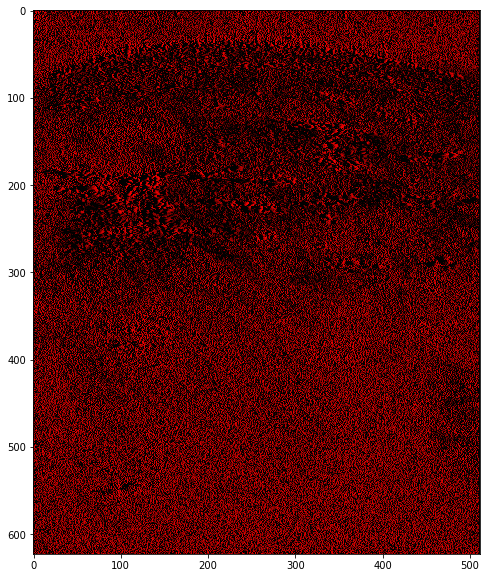

In [283]:
print(np.mean(m[0,:,:,0] - image_a.image.numpy()))
plt.figure(figsize=(20,10))
plt.imshow(visualization_utils.multiple_intensity_to_rgb(warp_values_[0,:,:,1].numpy()))

0.43038553


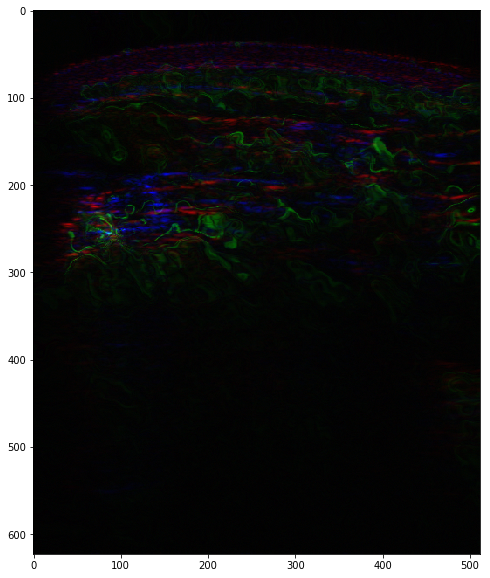

In [284]:
# Display.
print(np.mean(m[0,:,:,0] - image_a.image.numpy()))
plt.figure(figsize=(20,10))
plt.imshow(visualization_utils.multiple_intensity_to_rgb(image_a.image.numpy(),
                                             m[0,:,:,0].numpy(),
                                                        image_b.image.numpy()))